# Recusive Bayes Filter for Harmonic Exponential Distributions

## Fourier Series

$$
f(x) = \sum_{k=-\infty}^{\infty}\hat{f}_k e^{i 2 \pi k x}
$$

**Euler's Formula**:  $ e^{ix} = \textrm{cos}(x) +i \textrm{sin}(x)$

$$
\mathcal{F}[f(x)] = \hat{f}_k = \int f(x) e^{-i 2 \pi k x} dx
$$

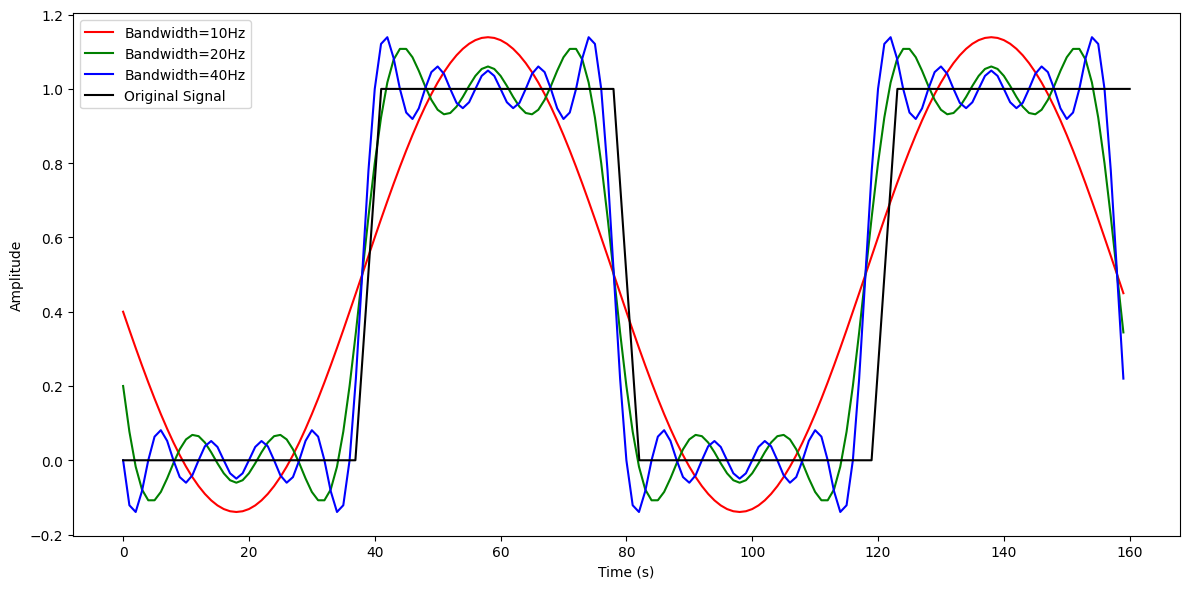

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from numpy.fft import rfft, irfft

x = np.hstack([np.zeros(10), np.ones(10)])
x = np.hstack([x, x])
n = x.shape[0]

X = rfft(x)
X_10 = np.zeros(X.shape, dtype = X.dtype)
X_10[:6] = X[:6]

X_20 = np.zeros(X.shape, dtype = X.dtype)
X_20[:11] = X[:11]

X_40 = np.zeros(X.shape, dtype = X.dtype)
X_40[:21] = X[:21]



plt.figure(figsize = (12, 6))
plt.plot(irfft(X_10, n=160) * 4 , 'r', label="Bandwidth=10Hz")
plt.plot(irfft(X_20, n=160) * 4 , 'g', label="Bandwidth=20Hz")
plt.plot(irfft(X_40, n=160) * 4 , 'b', label="Bandwidth=40Hz")

t = np.linspace(0, 160, num=40)
plt.plot(t, x, 'k', label="Original Signal")
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.tight_layout()
plt.legend()
plt.show()

## Fourier Transform on Compact Groups

### Irreducible Unitary Represenations for Groups

#### Representations
A mapping $R()$ from group $G$ to the general linear group $GL$ of a vector space $V$, or $GL(V)$ that respects the group compostions of group $G$.

$$
\forall g,h \in G, R(g\cdot h) = R(g)R(h)
$$

#### Unitary Representation
A representation, $U()$ that do not change the norm of vectors they act on.

$$
\forall g \in G, ||U(g)x|| = ||x||
$$

#### Irreducible Unitary Representations
Unitary Representations are Irreducible if there exist no Matrix $F$ that can act on a representation $U()$ to diagonalize it for all $g$ in group $G$

$$
\forall g \in G, T(g) = F^{-1} U(g) F
$$

#### Example of IUR for S1 Group

An **IUR** For $S1$ is 
$$
U^\lambda_n (g) =[e^{i\lambda m g}]
$$

It's a Representation because

$$
T^{\lambda}_{0}(g) = e^{i\lambda g}\\
T(g\cdot h) = T(g) T(h) \\
e^{i\lambda (g \cdot h)} = e^{i\lambda g} e^{i \lambda h}
$$

It's Unitary because
$$
\forall g \in G, ||U^\lambda_m(g)|| = 1
$$

and it's Irreducible because it's already a $1x1$ matrix so can't be diagonalized further.

### Fourier Analysis with IUR

The Fourier analysis of function $f()$ on group $G$ can be done with IUR $T()$

$$
\eta^\lambda_{m,n} = \int_{G} f(g) \cdot T^\lambda_{m} (g) du(g)
= \mathcal{F} f(g)
$$

and the inverse Fourier transform is

$$
f(g) = \sum_\lambda \sum_{m} \eta^\lambda_m T^\lambda_{m}(g)
$$



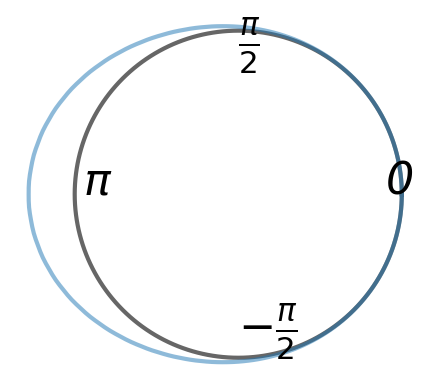

In [2]:
import numpy as np
import matplotlib.pyplot as plt

from src.distributions.s1_distributions import S1Gaussian
from src.spectral.s1_fft import S1FFT
from src.sampler.s1_sampler import S1Sampler
from src.utils.s1_plotting import plot_s1_spectral

b = 100
oversampling_factor = 2
grid = S1Sampler(n_samples=b).sample()
fft = S1FFT(bandwidth=b, oversampling_factor=2)
s1_gaussian = S1Gaussian(mu_theta=np.pi, cov=0.5, samples=grid, fft=fft)

plot_s1_spectral([s1_gaussian.eta], distribution=s1_gaussian, use_exp=True)
plt.show()

## Harmonic Exponential Distributions on Compact Groups

>**Harmonic Exponential Families on Manifolds**, Taco Cohen, Max Welling; *Proceedings of the 32nd International Conference on Machine Learning*, PMLR 37:1757-1765 

We can represent an arbitrary function on a group with the expression $ \eta \cdot T(g)$.

How do we make it an arbitrary probability distribution?

- Make it non-negative by passing it through $\text{exp}(\cdot)$

- Make it integrate to 1 by adding a normalization constant $Z_n$

That gives us the following form for the **Harmonic Exponential Distribution**.

$$
p(g;\eta) = \frac{1}{Z_N}\text{exp}(\eta \cdot T(g))
$$

The following chart shows how we can get between the various parametrizations of the distribution.

<img src="media/spaces.svg" width="400" align="center">


#### Computing Moments

To be a valid probability distribution, we need to compute the correct normalization constant $Z_N$. Luckily, the Fourier Coefficents contain that information.

$$
\eta^0_{0} = \int_{G} f(g) \cdot T^0_{0} (g) du(g) \\
= \int_{G} f(g) \cdot e^{(i\cdot 0 \cdot g)} \\
= \int_{G} f(g)
$$

Therefor, $Z_N$ is the $\eta^0_{0,0}$ Fourier coefficent of $\text{exp}(\eta \cdot T(g))$


### Cool Properties of Harmonic Exponential Distributions

- Can be extended to any group with a **IUR**.

- Both the [(log-)likelihood](https://github.com/saparkison/lie_learn/blob/c38c13c8c07810c32be17d49431a47a6afc26bb5/lie_learn/probability/S2HarmonicDensity.py#L143) calculation and [fft](https://pytorch.org/docs/stable/fft.html) are differentiable.

- Prodcut of two Harmonic Exponential Distributions is the element wise sum of their $\eta$ coefficients.

## Bayes filter

Find $bel(x_t)$ given $bel(x_{t-1}), u_t, z_t$

$$
p(x_i| z_{1:t},u_{1:t}) = n p(z_t|x_t, z_{1:t-1}, u_{1:t-1}) p(x_t|z_{1:t-1}, u_{1:t})
$$

### Predict

$$
\overline{bel}(x_t) = \int p(x_t|u_t, x_{t-1}) bel(x_{t-1}) dx_{t-1}
$$

### Update

$$
bel(x_t) = n p(z_t|x_t) \overline{bel}(x_t)
$$


### Existing Bayes Filters

#### Kalman Filter
Best Linear Unbiased Estimator for *Linear Systems* with *Gaussian Noise*.

**Predict**
$$
\hat{x}_{t|t-1} = F_t x_{t-1|t-1} + B_t u_t\\
\hat{P}_{t|t-1} = F_t P_{t-1|t-1} F_t^\top + R_t
$$

**Update**

$$
y_t = z_t - H_t \hat{x}_{t|t-1}\\
S_t = H_t \hat{P} H_t^\top + Q_t\\
K_t = \hat{P}_{t|t-1} H_t^\top S_t^{-1}\\
x_{t|t} = \hat{x}_{t|t-1} +K_t y_t\\
P_{t|t} = (I -K_t H_t) \hat{P}_{t|t-1}
$$

#### Extended Kalman Filter

State update and measurement models are no longer considered to be linear. Instead we linearize them by using their first order approximation

$$
x_t = f(x_{t-1}, u_t) + w_t\\
F_t = \frac{\partial f}{\partial x_{t-1}}\\
z_t  = h(x_t) + v_t\\
H_t = \frac{\partial h}{\partial x_t}
$$

#### Particle Filter

A sequential Monte Carlo approach where you sample through the motion $f()$ and measurement $h()$ models.

### Bayesian Prediction Step as the Convolution of Harmonic Exponential Distributions

The predict step includes the the probability of the current pose $x_t$ give the previous pose $x_{t-1}$ and control imput $u_t$ if we assume the update is fully defined by the control input, the motion model becomes the likelihood of the relative motion from $x_{t-1}$ to $x_t$, or $x_{t} \cdot x^{-1}_{t-1}$ matching the motion $b(u_t)$ or $p_{u_t} ( x_{t} \cdot x^{-1}_{t-1})$ and our prediction step becomes

$$
\overline{bel}(x_t) = \int p(x_t|u_t, x_{t-1}) bel(x_{t-1}) dx_{t-1}\\
= \int p_{u_t} (x_{t} \cdot x^{-1}_{t-1}) bel(x_{t-1}) dx_{t-1} \\
= (p_{u_t} \ast bel ) (x_{t-1})\\
= \mathcal{F}^{-1}[\mathcal{F}[p_{u_t}] \cdot \mathcal{F}[bel]](x_{t-1})
$$

where $\ast$ is the convolution operator. 

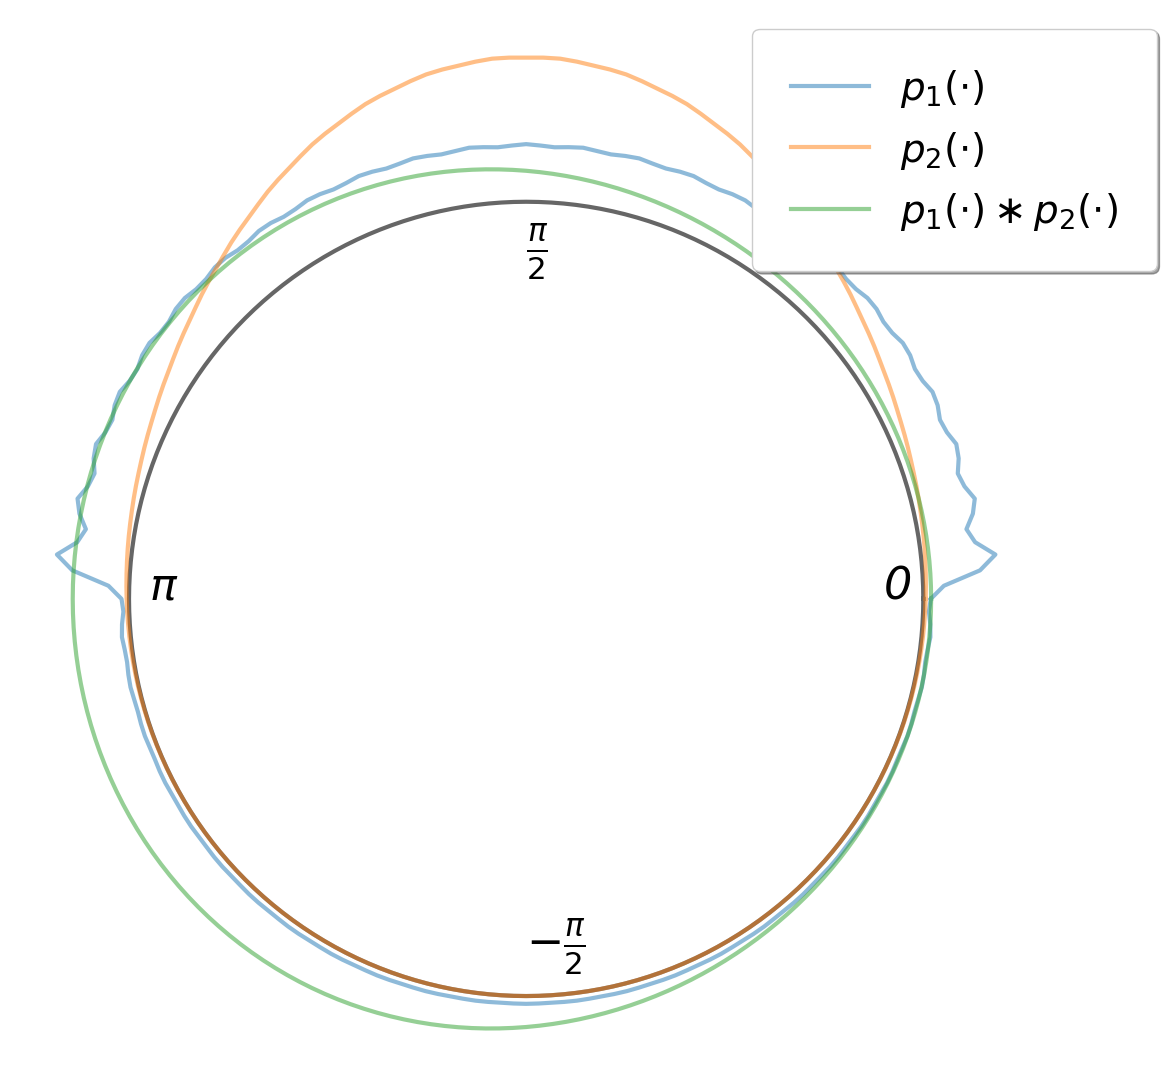

In [3]:
import numpy as np
import matplotlib.pyplot as plt

from src.distributions.s1_distributions import S1Gaussian, StepS1, S1
from src.spectral.s1_fft import S1FFT
from src.sampler.s1_sampler import S1Sampler
from src.utils.s1_plotting import plot_s1_spectral

b = 100
oversampling_factor = 2
grid = S1Sampler(n_samples=b).sample()
fft = S1FFT(bandwidth=b, oversampling_factor=2)
s1_gaussian = S1Gaussian(mu_theta=np.pi / 2.0, cov=0.3, samples=grid, fft=fft)
s1_step = StepS1(up=0, down=np.pi, scale=2.0, samples=grid,  fft=fft)
# Compute convolution - this will automatically compute etas of both distributions (normalize)
dist = S1.convolve(s1_gaussian, s1_step)

fig = plt.figure(figsize=(12,12), dpi= 100)
ax = fig.add_subplot(111)
legend = [rf"$p_1(\cdot)$", rf"$p_2(\cdot)$", rf"$p_1(\cdot)\ast p_2(\cdot)$"]
plot_s1_spectral([s1_step.eta, s1_gaussian.eta, dist.eta], legend=legend, distribution=s1_gaussian, use_exp=True, ax=ax)
#plot_s1_spectral([s1_gaussian.eta], distribution=s1_gaussian, use_exp=True)
#plot_s1_spectral([dist.M], distribution=s1_gaussian, use_exp=False)
ax.legend(bbox_to_anchor=(0.7, 1.0), loc='upper left', fancybox=True, framealpha=1, shadow=True, borderpad=1, fontsize="28")
plt.tight_layout()
plt.savefig("conv.png", transparent=True)
plt.show()

### Bayesian Update Step as the Product of Harmonic Exponential Distributions

The update step of a bayes filter is the product of two distributions,
$p(z_t|x_t) \overline{bel}(x_t)$. If both distributions are Harmonic Exponential Distributions, their product can be found by summing their Fourier coefficents $\eta$

$$
p(g) = p_a (g) p_b (g) = exp(\eta_a \cdot T(g)) exp(\eta_b \cdot T(g))\\
= exp(\eta_a \cdot T(g) + \eta_b \cdot T(g)) \\
= exp((\eta_a + \eta_b) \cdot T(g))
$$

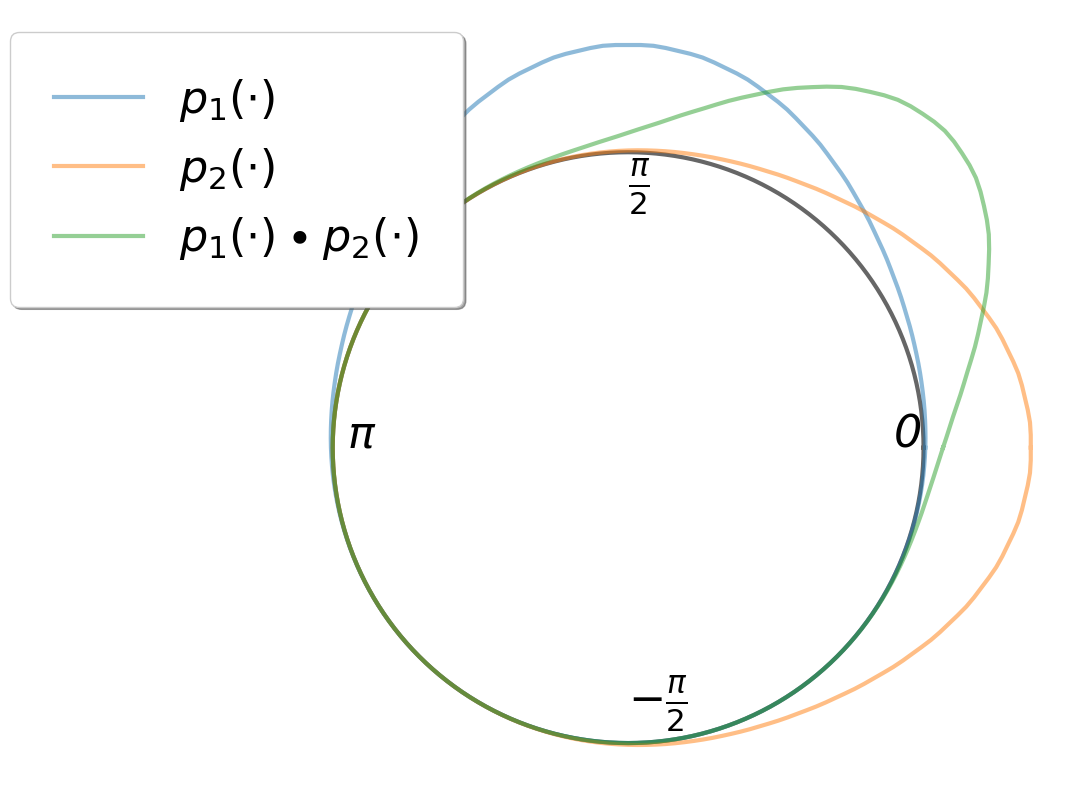

In [4]:
import numpy as np
import matplotlib.pyplot as plt

from src.distributions.s1_distributions import S1Gaussian, S1
from src.spectral.s1_fft import S1FFT
from src.sampler.s1_sampler import S1Sampler
from src.utils.s1_plotting import plot_s1_spectral

b = 100
oversampling_factor = 2
grid = S1Sampler(n_samples=b).sample()
fft = S1FFT(bandwidth=b, oversampling_factor=2)
s1_gaussian1 = S1Gaussian(mu_theta=np.pi / 2.0, cov=0.3, samples=grid, fft=fft)
s1_gaussian2 = S1Gaussian(mu_theta=0.0, cov=0.3, samples=grid, fft=fft)

dist = S1.product(s1_gaussian1, s1_gaussian2)

fig = plt.figure(figsize=(12,8), dpi= 100)
ax = fig.add_subplot(111)
legend = [rf"$p_1(\cdot)$", rf"$p_2(\cdot)$", rf"$p_1(\cdot)\bullet p_2(\cdot)$"]
plot_s1_spectral([s1_gaussian1.eta, s1_gaussian2.eta, dist.eta], distribution=s1_gaussian1, use_exp=True, legend=legend, ax=ax)
ax.legend(bbox_to_anchor=(-0.4, 1.0), loc="upper left", fancybox=True, framealpha=1, shadow=True, borderpad=1, fontsize="32")
plt.tight_layout()
plt.savefig("prod.png", transparent=True)
#plot_s1_spectral([s1_gaussian2.eta], distribution=s1_gaussian1, use_exp=True)
#plot_s1_spectral([dist.M], distribution=s1_gaussian1, use_exp=True)
plt.show()

## Running the full Bayes filter on S1

The following two blocks will run the Bayes filter on S1. The second block has to be run multiple times to iterate the filter.

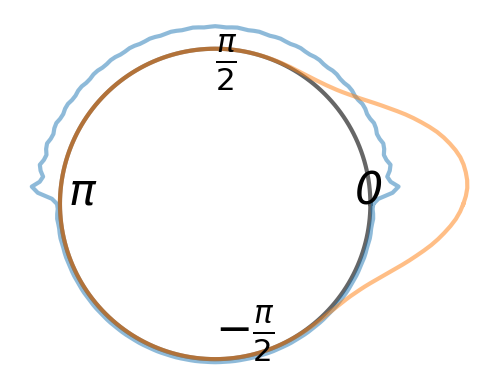

In [5]:
import numpy as np
import matplotlib.pyplot as plt

from src.distributions.s1_distributions import S1, S1Gaussian, StepS1, S1MultimodalGaussian
from src.spectral.s1_fft import S1FFT
from src.sampler.s1_sampler import S1Sampler
from src.simulators.s1_simulator import S1Simulator
from src.utils.s1_plotting import plot_s1_spectral
from src.filters.bayes_filter import BayesFilter

b = 100
oversampling_factor = 2
# Define motion and measurement noise
motion_noise, measurement_noise = np.sqrt(0.1), np.sqrt(0.4)
grid = S1Sampler(n_samples=b).sample()
fft = S1FFT(bandwidth=b, oversampling_factor=2)
simulator = S1Simulator(step=0.1, samples=grid, fft=fft,
                        motion_noise=motion_noise, measurement_noise=measurement_noise)

prior = StepS1(up=0, down=np.pi, scale=2.0, samples=grid, fft=fft)
motion_model = S1Gaussian(mu_theta=simulator.step, cov=motion_noise**2, samples=grid, fft=fft)

plot_s1_spectral([prior.eta, motion_model.eta], distribution=motion_model, use_exp=True)
plt.show()

# Define Filter and dummy measurement model
filter = BayesFilter(distribution=S1, prior=prior)
it = 1

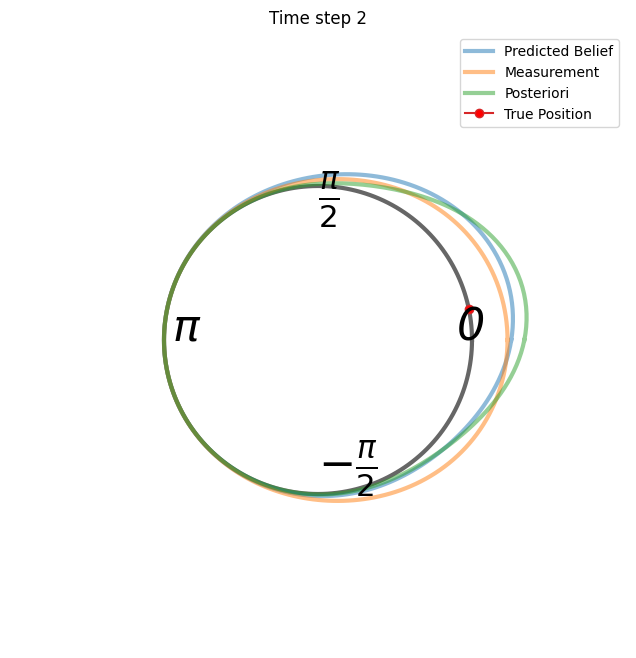

In [7]:
# Predict step
belief_hat = filter.prediction(motion_model=simulator.motion()).eta
# Update step
posteriori_hat, measurement = filter.update(measurement_model=simulator.measurement())
posteriori_hat = posteriori_hat.eta
measurement_hat = measurement.eta

fig = plt.figure(figsize=(12,8), dpi= 100)
legend = [rf"Predicted Belief", rf"Measurement", rf"Posteriori"]

ax = fig.add_subplot(111)
plot_s1_spectral([belief_hat, measurement_hat, posteriori_hat], prior, legend = legend, ax=ax, use_exp=True)

# Plus np.pi because our plots are rottated. 
c = np.cos(simulator.theta)  # + np.pi)
s = np.sin(simulator.theta)  # + np.pi)
ax.plot(c, s, marker='o', markerfacecolor="r", label=rf"True Position")

ax.set_xlim([-2, 2])
ax.set_ylim([-2, 2])

ax.legend()
ax.set_title(rf"Time step {it}")
fig.savefig(f"bayes_filter{it:03d}.png")

plt.show()

it += 1

## Final result on S1

<img src="media/bayes_filter.gif" width="1000" align="center">



## Comparing to Sampling Approaches

>**Non-parametric Mixed-Manifold Products using Multiscale Kernel Densities**, D. Fourie, P. V. Teixeira and J. Leonard, *2019 IEEE/RSJ International Conference on Intelligent Robots and Systems (IROS)*

<img src="media/products.svg">